4. Model Selection
 Choose Algorithms:
 Evaluate models like Random Forest, Gradient Boosting Machines (e.g., XGBoost), or neural networks (RNN/LSTM for sequential data).
 Decide on the best model based on data type and problem complexity.
 Split Data:
 Split the data into training and testing sets (e.g., 80/20 or 70/30 split).

In [28]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [29]:
# Data Preparation with Country Considerations

# Defining target and features 

# Checking for leakage
# Define features to EXCLUDE (potential leakage)

data_fe = pd.read_csv('H:/Study/IPCA/MIAA/MLA/TP2025/DataS1/jaguar_movement_with_countries_climate_data.csv')
leaky_features = [
    'velocity', 
    'acceleration', 
    'distance', 
    'time_diff', 'direction',
    'change_in_direction', 'movement'
]

# Safe features to include
base_features = [
    'location_long', 'location_lat', 'country', 'study_name',
    'individual_taxon_canonical_name', 'hour', 'day', 'month_x', 'year_x',
    'mean_daily_maximum_air_temperature', 'mean_daily_minimum_air_temperature'
]

target = 'movement'
# features = [col for col in data_fe.columns if col not in [target, 'event_id', 'timestamp', 'date']]
features = [col for col in data_fe.columns if col in base_features]
categorical_features = ['country', 'study_name', 'individual_taxon_canonical_name']
numeric_features = [col for col in features if col not in categorical_features + [target]]
data_fe['stratify_col'] = data_fe['country'] + '_' + data_fe[target]

# Filter out classes with fewer than two samples
class_counts = data_fe['stratify_col'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
data_fe_filtered = data_fe[data_fe['stratify_col'].isin(valid_classes)]

data_fe_filtered = data_fe_filtered.reset_index(drop=True) 

# Splitting the data with stratification by both country and movement class
X_train, X_test, y_train, y_test = train_test_split(
    data_fe_filtered[features], 
    data_fe_filtered[target],
    test_size=0.2,
    stratify=data_fe_filtered['stratify_col'],
    random_state=42
)

# print(X_train.shape, X_test.shape)
# print(X_train.columns, X_test.columns)

# Model Selection
models = {
    # Handles categorical features natively, good for country-wise patterns
    'CatBoost': CatBoostClassifier(
        cat_features=categorical_features,
        auto_class_weights='Balanced',
        verbose=0,
        random_seed=42
    ),
    
    # Baseline for comparison
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100,
        random_state=42
    ),
    
    # Gradient boosting alternative
    'XGBoost': XGBClassifier(
        scale_pos_weight='balanced',
        enable_categorical=False,  # Requires pre-encoded categories
        random_state=42
    )
}

5. Model Training and Evaluation
 Train Models:
 Train selected models using the preprocessed data.
 Use cross-validation to tune model parameters.
 Evaluate Model:
 Evaluate performance using metrics like accuracy, precision, recall, and F1-score.
 If the dataset is imbalanced, apply techniques like SMOTE to balance it.


=== CatBoost ===
CV F1-weighted: 0.980 ± 0.002
Test Set Performance:
              precision    recall  f1-score   support

     hunting       0.06      0.11      0.07         9
    movement       0.99      0.98      0.99      2203
     stopped       0.15      0.23      0.18        13

    accuracy                           0.98      2225
   macro avg       0.40      0.44      0.41      2225
weighted avg       0.98      0.98      0.98      2225


=== Random Forest ===
CV F1-weighted: 0.985 ± 0.000
Test Set Performance:
              precision    recall  f1-score   support

     hunting       0.00      0.00      0.00         9
    movement       0.99      1.00      0.99      2203
     stopped       0.00      0.00      0.00        13

    accuracy                           0.99      2225
   macro avg       0.33      0.33      0.33      2225
weighted avg       0.98      0.99      0.98      2225


=== XGBoost ===


c:\Users\Guima\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Guima\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Guima\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are no

CV F1-weighted: 0.984 ± 0.001
Test Set Performance:
              precision    recall  f1-score   support

     hunting       0.00      0.00      0.00         9
    movement       0.99      1.00      0.99      2203
     stopped       0.00      0.00      0.00        13

    accuracy                           0.99      2225
   macro avg       0.33      0.33      0.33      2225
weighted avg       0.98      0.99      0.98      2225



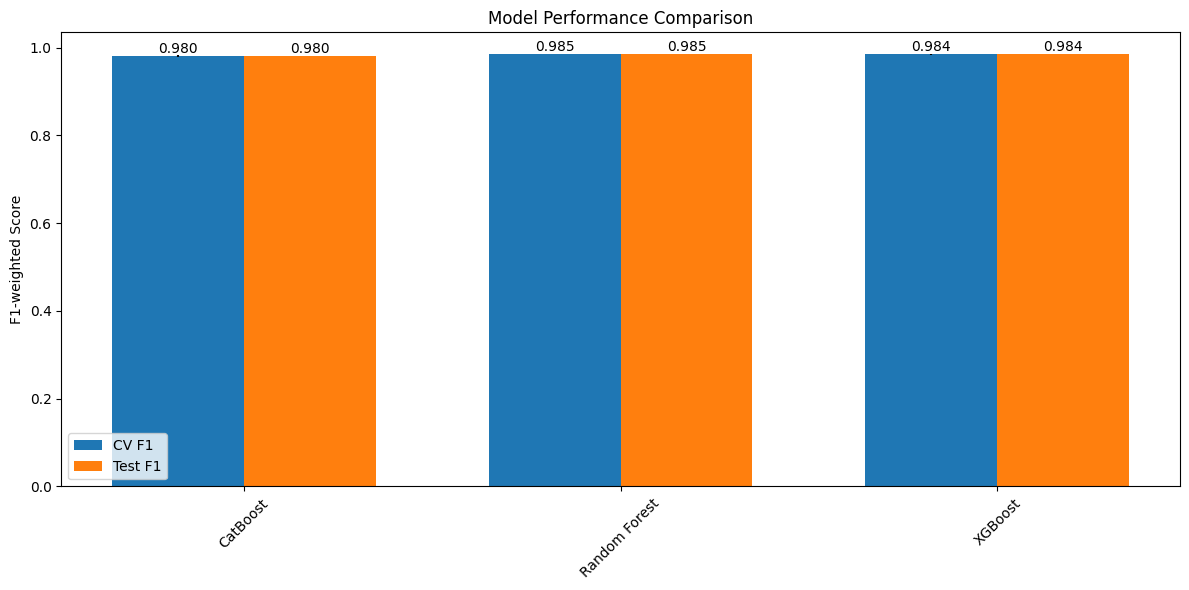

In [31]:
le = LabelEncoder()

# Encoding target labels for non cat boost models
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

metrics = {
    'cv_mean': [],
    'cv_std': [],
    'test_f1': []
}
model_names = []


for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Special handling for CatBoost
    if name == 'CatBoost':
        # Convert categorical columns to string type
        X_train[categorical_features] = X_train[categorical_features].astype(str)
        X_test[categorical_features] = X_test[categorical_features].astype(str)
        
        # Specify categorical features when fitting
        model.fit(X_train, y_train, cat_features=categorical_features)
    else:
        # One-hot encode categorical features for other models
        X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)
        X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)
        
        # Align columns between train and test
        X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
        
        model.fit(X_train_encoded, y_train_encoded)

    # groups = data_fe_filtered.loc[X_train.index, 'country'].values
    
    # Cross-validate with regional stratification
    cv_scores = cross_val_score(
        model, 
        X_train if name == 'CatBoost' else X_train_encoded,
        y_train if name == 'CatBoost' else y_train_encoded,
        cv=5, 
        scoring='f1_weighted',
        # groups=groups
    )

    print(f"CV F1-weighted: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    
    # Evaluate on test set
    if name == 'CatBoost':
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_encoded)
    
    if name != 'CatBoost':
        y_pred = le.inverse_transform(y_pred)
    
    print("Test Set Performance:")
    print(classification_report(y_test, y_pred))

    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    metrics['cv_mean'].append(cv_mean)
    metrics['cv_std'].append(cv_std)

    # Calculate and store test F1
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    metrics['test_f1'].append(test_f1)
    
    # Append model name
    model_names.append(name)

plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.35

rects1 = plt.bar(x - width/2, metrics['cv_mean'], width, 
                yerr=metrics['cv_std'], label='CV F1')
rects2 = plt.bar(x + width/2, metrics['test_f1'], width, 
                label='Test F1')

plt.ylabel('F1-weighted Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.tight_layout()

for rect in rects1 + rects2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

plt.show()

    

In [ ]:
# Display model feature importances
if name == 'CatBoost':
    feature_importances = model.get_feature_importance()
else:
    feature_importances = model.feature_importances_

feature_importances = pd.Series(feature_importances, index=X_train_encoded.columns)
feature_importances = feature_importances.sort_values(ascending=False)

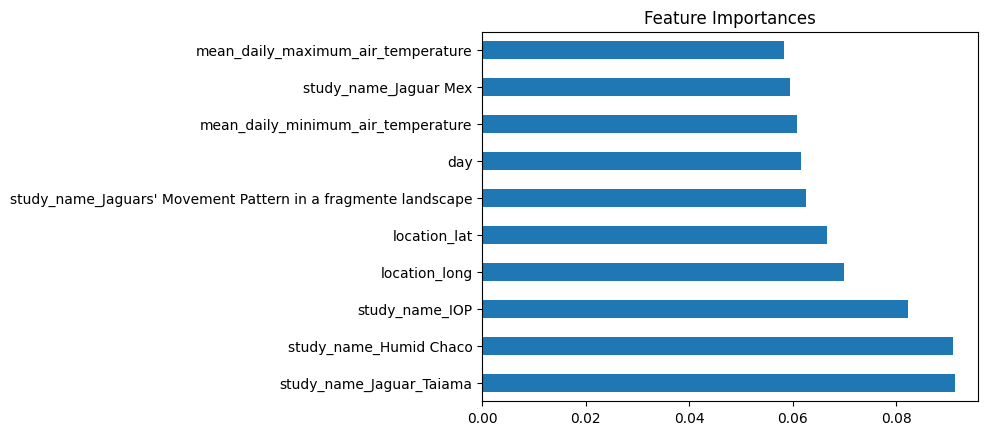

In [ ]:
# Plot feature importances
feature_importances.head(10).plot(kind='barh', title='Feature Importances')
plt.show()

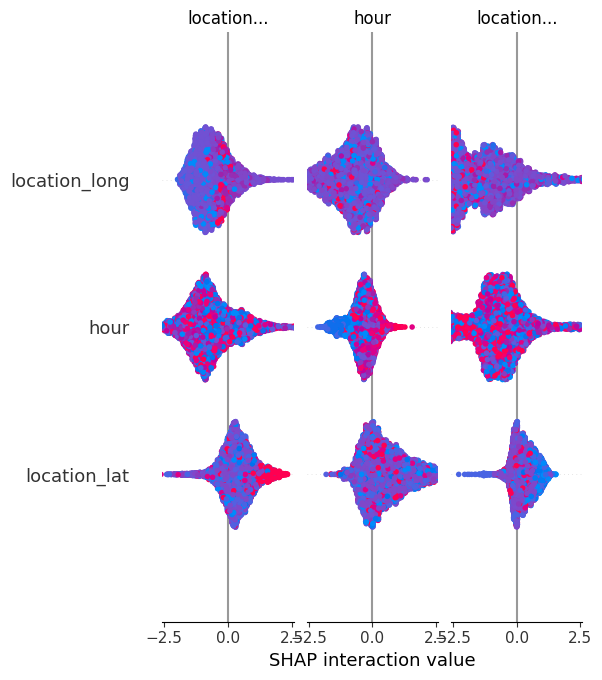

In [ ]:
# SHAP Feature Importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_encoded)

# For multi-class models, sum the SHAP values across the classes
if isinstance(shap_values, list):
    shap_values = np.sum(shap_values, axis=0)

shap.summary_plot(shap_values, X_train_encoded, plot_type='bar')